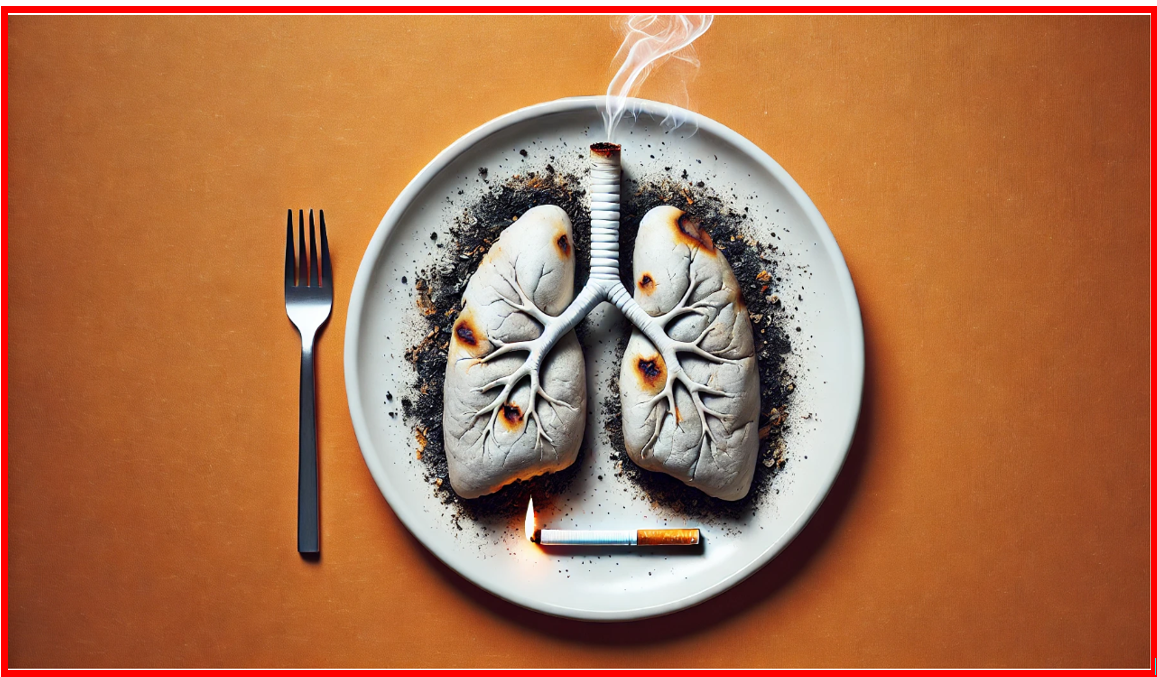


# Smoker Dataset
## Module 10.13 Assignment 10: Final Project
Dec. 2024

Authors: Tyler Earps, Ryan Smith, Basil Mullings, & Ean Vandergraaf


## Abstract and Data Description


### Abstract

This team project will use the Kaggle Smoker Dataset with 150+K rows and 20+ columns, which aims to analyze patterns and identify predictor items related to smoking habits.  This is a rather different/unique dataset – meaning that the data is not actually collected/procured over time, but instead was synthetically generated from another dataset using a deep learning model.  By examining a variety of demographic, lifestyle, and health-related variables, our study seeks to uncover any meaningful associations that could possible influence an individual's likelihood of smoking. Using exploratory data analysis and supervised machine learning models, such as logistic regression, decision trees, and possible ensemble methods, we will strive to identify key features that distinguish smokers from non-smokers. Our findings from this analysis could possible inform public health strategies by highlighting significant factors contributing to smoking behavior, and ultimately supporting targeted interventions and health education efforts, and even possible significant life style changes.  This is a binary classification task, and we hope that additional feature engineering aspects of the dataset will also be fruitful.


https://www.kaggle.com/competitions/playground-series-s3e24/data?select=train.csv


<div style="border-radius: 10px; background-color: #F4A300 ">
    <h1 style="color: white; padding: 1rem">      Data Attributes detail     </h1>
</div>


A quick breakdown on information the dataset contains. It has the following **features** (columns):

- **<span style="color: turquoise">age</span>**: Age in years
- **<span style="color: turquoise">height(cm)</span>**: Height of the person in Centimeters
- **<span style="color: turquoise">weight(kg)</span>**: Weight of the person in Kilograms
- **<span style="color: turquoise">waist(cm)</span>**: Waist length in centimeters
- **<span style="color: turquoise">eyesight(left)</span>**: Vision measurement in the left eye
- **<span style="color: turquoise">eyesight(right)</span>**: Vision measurement in the right eye
- **<span style="color: turquoise">hearing(left)</span>**: Hearing measurement in the left ear
- **<span style="color: turquoise">hearing(right)</span>**: Hearing measurement in the right ear
- **<span style="color: turquoise">systolic</span>**: Systolic blood pressure, measures the pressure in your arteries when your heart beats
- **<span style="color: turquoise">relaxation</span>**: Relaxation is the process by which heart muscle actively returns, after contraction, to its initial conditions of load and length
- **<span style="color: turquoise">fasting blood sugar</span>**: This measures your blood sugar after an overnight fast (not eating)
- **<span style="color: turquoise">Cholesterol</span>**: Measure of cholesterol levels
- **<span style="color: turquoise">triglyceride</span>**: Level of triglycerides
- **<span style="color: turquoise">HDL</span>**: HDL (high-density lipoprotein) cholesterol, sometimes called “good” cholesterol
- **<span style="color: turquoise">LDL</span>**: LDL (low-density lipoprotein) cholesterol, sometimes called “bad” cholesterol
- **<span style="color: turquoise">hemoglobin</span>**: Hemoglobin levels in blood
- **<span style="color: turquoise">Urine protein</span>**: Measure of protein in urine
- **<span style="color: turquoise">serum creatinine</span>**: Meaure of serum creatinine in the body
- **<span style="color: turquoise">AST</span>**: AST (aspartate aminotransferase) This is an Liver enzyme
- **<span style="color: turquoise">ALT</span>**: ALT stands for alanine transaminase. This is another Liver enzyme
- **<span style="color: turquoise">Gtp</span>**: Energy-rich nucleotide analogous to ATP
- **<span style="color: turquoise">dental caries</span>**: Dental issue of the person (boolean)
- **<span style="color: turquoise">smoking</span>**: Whether the person smokes or not.  This is our target variable.

### Stage 0: Import Data

In [6]:
# Downlod the data
# https://www.kaggle.com/competitions/playground-series-s3e24/data?select=train.csv

# Extract train.csv & test.csv to folder "./Data" in the same directory as repo

In [55]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, mean, countDistinct, format_number, when, explode, lower
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.clustering import KMeans, GaussianMixture
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder.appName("SmokerStatusPrediction").getOrCreate()

###Loading the Dataset

#file_path = "data/train.csv"
#data = spark.read.csv(file_path, header=True, inferSchema=True)

#Load Kaggle data into a DataFrame
def csvToDF(fileName):
    return spark.read\
                .format("csv")\
                .option("header", "true")\
                .option('escape','"')\
                .load(fileName)

    
df_train = csvToDF("data/train.csv")
df_test = csvToDF("data/test.csv")

#Cast all columns to double
df_train = df_train.select([col(column).cast('double') for column in df_train.columns])
df_test = df_test.select([col(column).cast('double') for column in df_test.columns])


##Show the number of rows and columns in one statement
print('#=> Number of rows and columns:')
print(f"Rows: {df_train.count()}, Columns: {len(df_train.columns)}")
print("\n")

##Show our basic statistics
print('#=> Summary of statistics for our Training data :')
df_train.summary().show()
print("\n")

##Show the data schema
print('#=> Training data schema:')
df_train.printSchema()
print("\n")

##List the column names 
print('#=> Column names:')
print(df_train.columns)
print("\n")

##Verify any null relevant data in any of our columns.
print('#=> Training dataset with Null values:')
df_train.select([count(when(col(c).isNull(), c )).alias(c) for c in df_train.columns]).show()
print("\n")





#=> Number of rows and columns:
Rows: 159256, Columns: 24


#=> Summary of statistics for our Training data :
+-------+-----------------+------------------+-----------------+------------------+-----------------+-------------------+------------------+-------------------+-------------------+------------------+-----------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+
|summary|               id|               age|       height(cm)|        weight(kg)|        waist(cm)|     eyesight(left)|   eyesight(right)|      hearing(left)|     hearing(right)|          systolic|       relaxation|fasting blood sugar|       Cholesterol|      triglyceride|               HDL|               LDL|        hemoglobin|     Urine protein|  serum creatinine|               AST|               ALT|               

### Stage 1: Data Preparation

<i>EDA & Any adjustments to clean the data</i>

+-------+-----------------+------------------+-----------------+------------------+-----------------+-------------------+------------------+-------------------+-------------------+------------------+-----------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+
|summary|               id|               age|       height(cm)|        weight(kg)|        waist(cm)|     eyesight(left)|   eyesight(right)|      hearing(left)|     hearing(right)|          systolic|       relaxation|fasting blood sugar|       Cholesterol|      triglyceride|               HDL|               LDL|        hemoglobin|     Urine protein|  serum creatinine|               AST|               ALT|               Gtp|     dental caries|            smoking|
+-------+-----------------+------------------+-----------------+--

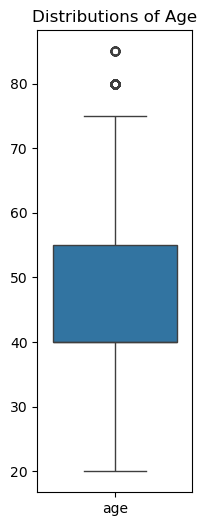

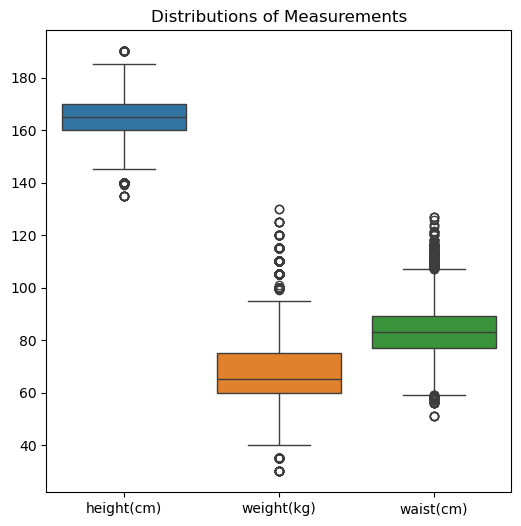

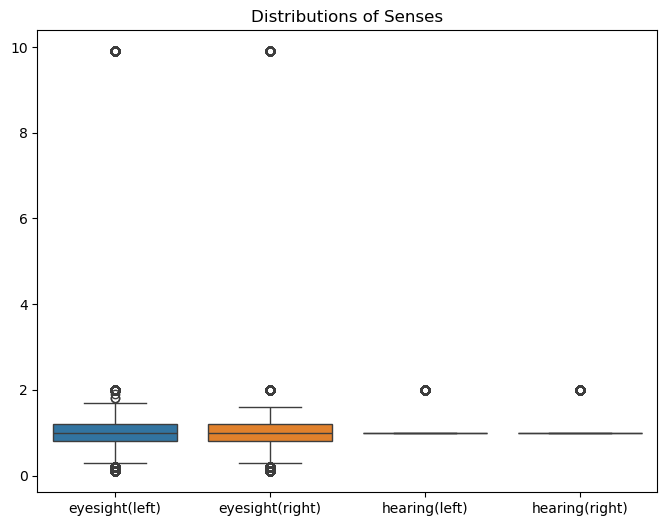

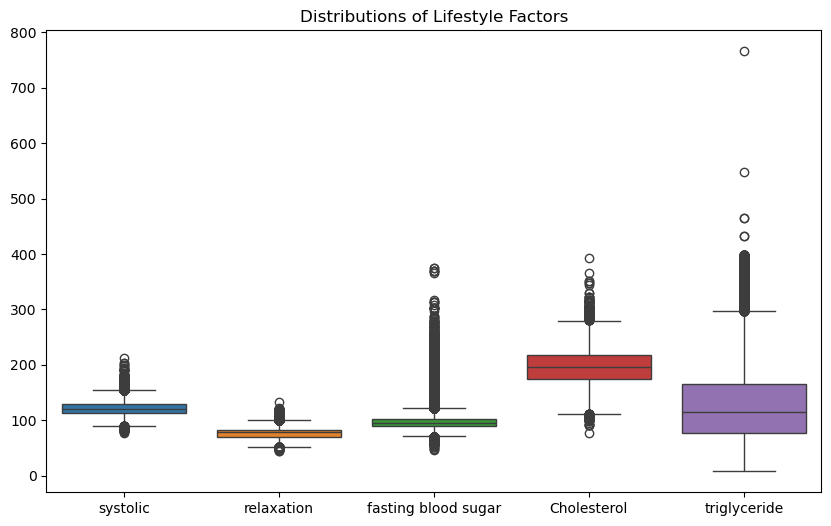

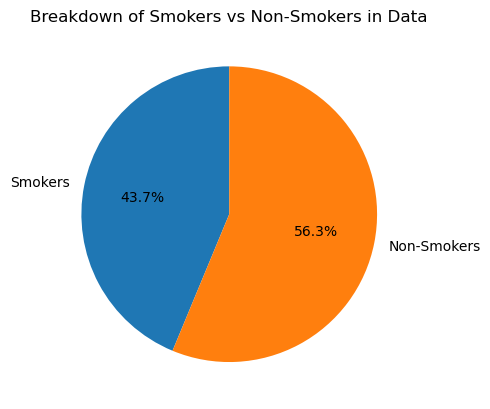

In [57]:
# Find most important features
# Do some box and whisker charts
# Decide if any transformations need to be made

df_train.describe().show()

def box_chart(df, title):
    plt.figure(figsize=(len(df.columns)*2, 6))
    sns.boxplot(data=df)
    plt.title(title)
    plt.show()

## Distributions
print('Distributions within the dataset')
df_train_age = df_train.select('age').toPandas()
box_chart(df_train_age,"Distributions of Age")

df_train_measurements = df_train.select('height(cm)', 'weight(kg)', 'waist(cm)').toPandas()
box_chart(df_train_measurements,"Distributions of Measurements")

df_train_senses = df_train.select('eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)').toPandas()
box_chart(df_train_senses,"Distributions of Senses")

df_train_lifestyle = df_train.select('systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride').toPandas()
box_chart(df_train_lifestyle,"Distributions of Lifestyle Factors")

## Binary Analysis
df_train_smokers = df_train.filter('smoking == 1').count()
df_train_non_smokers = df_train.filter('smoking == 0').count()
y = np.array([df_train_smokers, df_train_non_smokers])
labels = ['Smokers', 'Non-Smokers']
plt.title('Breakdown of Smokers vs Non-Smokers in Data')
#plt.pie(y, labels = labels, startangle=90)
plt.pie(y, labels = labels, autopct='%1.1f%%', startangle=90)
plt.show() 





### Stage 2: Feature Extraction & Engineering



#=> Displaying processed train data:
+-------------------------------------------------------------------------------------------------------------+-------+
|scaled_features                                                                                              |smoking|
+-------------------------------------------------------------------------------------------------------------+-------+
|[55.0,165.0,60.0,81.0,0.5,0.6,1.0,1.0,135.0,87.0,94.0,172.0,300.0,40.0,75.0,16.5,1.0,1.0,22.0,25.0,27.0,0.0] |1.0    |
|[70.0,165.0,65.0,89.0,0.6,0.7,2.0,2.0,146.0,83.0,147.0,194.0,55.0,57.0,126.0,16.2,1.0,1.1,27.0,23.0,37.0,1.0]|0.0    |
+-------------------------------------------------------------------------------------------------------------+-------+
only showing top 2 rows

Correlation between id and smoking: -0.0006315552097787737
Correlation between age and smoking: -0.20603295889076992
Correlation between height(cm) and smoking: 0.4471110538118994
Correlation between weight(kg) and s

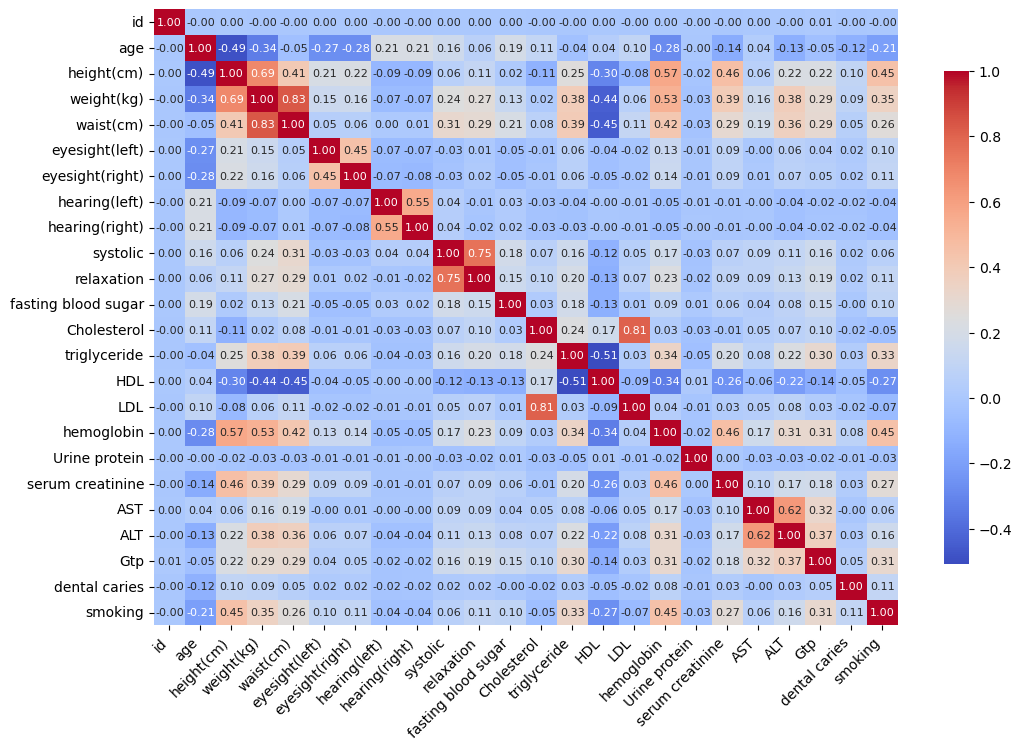

In [9]:
#from pyspark.ml.feature import FeatureHasher
#from pyspark.sql.functions import concat
#from pyspark.ml.feature import VectorAssembler, StandardScaler

# Split data from label
x_features = ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST', 'ALT', 'Gtp', 'dental caries']
y_features = ['smoking']


##Assemble features
assembler = VectorAssembler(inputCols=x_features, outputCol="scaled_features")
#transformed_data = assembler.transform(df_train)
transformed_data = assembler.transform(df_train).select("scaled_features", "smoking") 
#df_train_x = transformed_data
#scaled_data = df_train_x


##Standardize features
#scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
#scaled_data = scaler.fit(transformed_data).transform(transformed_data)
df_train_x = transformed_data
scaled_data = df_train_x


# Now display 2 rows of the processed train data.
print("\n")
print('#=> Displaying processed train data:')
df_train_x.show(n=2, truncate=False)


##Calculate correlations between the columns and smoking.
feature_columns = [col for col in df_train.columns if col != 'smoking']
for col_name in feature_columns:
    correlation = df_train.stat.corr(col_name, 'smoking')
    print(f"Correlation between {col_name} and smoking: {correlation}")


##Now convert to Pandas for visualization
pandas_data = df_train.toPandas()

##Increase the figure size
plt.figure(figsize=(12, 8))

##Create the correlation heatmap with a smaller annotation font size and rotated labels
sns.heatmap(pandas_data.corr(), annot=True, cmap="coolwarm", fmt='.2f',
            annot_kws={'size': 8},  ##Smaller annotation font size
            cbar_kws={'shrink': 0.8})  ##Shrink the color bar for better fit

##Rotate the axis labels for better readability
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

##Show the plot
print("\nNow displaying the correlation amongst the columns and smoking: ")
plt.show()


# Use RandomForestClassifier for feature importance ranking


### Stage 3: Machine Learning Algorithm Preparation and Parameter Tuning

In [78]:
###Train Supervised Machine Learning Models

# Train-test split
train, test = scaled_data.randomSplit([0.8, 0.2], seed=42)

evalScores = {}
accuracies = []
precisions = []
recalls = []
f1s = []

#'''
##Logistic Regression
print("\nNow working on Logistic Regression ...")
lr = LogisticRegression(featuresCol="scaled_features", labelCol="smoking")
lr_model = lr.fit(train)

##Logistic Regression Predictions
lr_predictions = lr_model.transform(test)
print("done!!")
#'''



#'''
##Decision Tree
##Instantiate Decision Tree Classifier with some initial hyperparameters
from pyspark.ml.classification import DecisionTreeClassifier
print("\nNow working on Decision Tree ...")
dt = DecisionTreeClassifier(featuresCol="scaled_features", labelCol="smoking",  maxDepth=5, maxBins=32)
dt_model = dt.fit(train)

##Decision Tree Predictions
dt_predictions = dt_model.transform(test)
print("done!!")
#'''



#'''
##Random Forest
print("\nNow working on Random Forest ...")
rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="smoking")
rf_model = rf.fit(train)

##Random Forest Predictions
rf_predictions = rf_model.transform(test)
print("done!!")
#'''



#'''
##Gradient-Boosted Trees
print("\nNow working on Gradient Boost ...")
gbt = GBTClassifier(featuresCol="scaled_features", labelCol="smoking")
gbt_model = gbt.fit(train)

##Gradient Boost Predictions
gbt_predictions = gbt_model.transform(test)
print("done!!")
#'''




Now working on Logistic Regression ...
done!!

Now working on Decision Tree ...
done!!

Now working on Random Forest ...
done!!

Now working on Gradient Boost ...
done!!



### Stage 4: Model Evaluation


#### Logistic Regresssion Evaluation

Logistic Regression AUC: 0.8321692803981319
Logistic Regression Accuracy: 0.7460568321901571
Logistic Regression Precision: 0.7473035300761548
Logistic Regression Recall: 0.7460568321901571
Logistic Regression F1 Score: 0.7464995311817222
+-------+----------+-----+
|smoking|prediction|count|
+-------+----------+-----+
|    1.0|       1.0|10050|
|    0.0|       1.0| 4263|
|    1.0|       0.0| 3771|
|    0.0|       0.0|13553|
+-------+----------+-----+



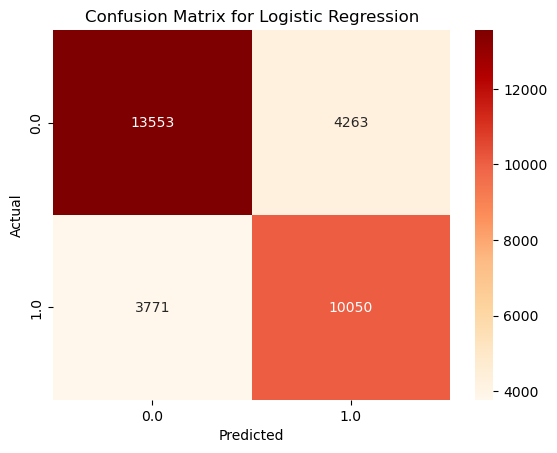

In [80]:
###Evaluate Logistic Regression

##Binary Classification Evaluator for AUC
evaluator = BinaryClassificationEvaluator(labelCol="smoking", metricName="areaUnderROC")
lr_auc = evaluator.evaluate(lr_predictions)
print(f"Logistic Regression AUC: {lr_auc}")

##Multiclass Classification Evaluator for accuracy
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="smoking", predictionCol="prediction", metricName="accuracy")
lr_accuracy = multiclass_evaluator.evaluate(lr_predictions)
print(f"Logistic Regression Accuracy: {lr_accuracy}")

precision = multiclass_evaluator.setMetricName("weightedPrecision").evaluate(lr_predictions)
print(f"Logistic Regression Precision: {precision}")

recall = multiclass_evaluator.setMetricName("weightedRecall").evaluate(lr_predictions)
print(f"Logistic Regression Recall: {recall}")

f1 = multiclass_evaluator.setMetricName("f1").evaluate(lr_predictions)
print(f"Logistic Regression F1 Score: {f1}")

evalScores["Logistic Regresssion"] = {"accuracy": lr_accuracy, "precision": precision, "recall": recall, "f1": f1}
accuracies.append(lr_accuracy)
precisions.append(precision)
recalls.append(recall)
f1s.append(f1)

##Confusion Matrix
lr_predictions.groupBy("smoking", "prediction").count().show()

##Visualize the Confusion Matrix

##Convert predictions to Pandas DataFrame
lr_pandas_predictions = lr_predictions.select("smoking", "prediction").toPandas()

##Create a confusion matrix
confusion_matrix = pd.crosstab(lr_pandas_predictions["smoking"], lr_pandas_predictions["prediction"], rownames=["Actual"], colnames=["Predicted"])

##Plot the confusion matrix
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="OrRd")
plt.title("Confusion Matrix for Logistic Regression")
plt.show()





####  Decision Tree Evaluation

AUC Score: 0.7397739937276812
Accuracy: 0.7490280367923634
Cross-Validated AUC Score: 0.7397739937276812
Cross-Validated Accuracy: 0.7490280367923634
Logistic Regression Precision: 0.761083713185319
Logistic Regression Recall: 0.7490280367923634
Logistic Regression F1 Score: 0.7499349426250741
+-------+----------+-----+
|smoking|prediction|count|
+-------+----------+-----+
|    1.0|       1.0|11158|
|    0.0|       1.0| 5277|
|    1.0|       0.0| 2663|
|    0.0|       0.0|12539|
+-------+----------+-----+



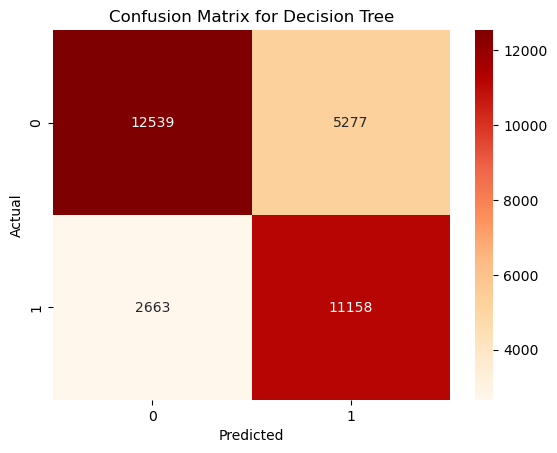

In [82]:
###Evaluate Decision  Tree Model
##Evaluate AUC using BinaryClassificationEvaluator


evaluator = BinaryClassificationEvaluator(labelCol="smoking", metricName="areaUnderROC")
auc_score = evaluator.evaluate(dt_predictions)
print(f"AUC Score: {auc_score}")

##Evaluate Accuracy using MulticlassClassificationEvaluator
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="smoking", predictionCol="prediction", metricName="accuracy")
accuracy = multiclass_evaluator.evaluate(dt_predictions)
print(f"Accuracy: {accuracy}")



##Cross-Validation with Hyperparameter Tuning
##Define the parameter grid
#paramGrid = ParamGridBuilder().addGrid(dt.maxDepth, [3, 5, 10]).addGrid(dt.maxBins, [16, 32, 64]).build()
paramGrid = ParamGridBuilder().addGrid(dt.maxBins, [16, 32, 64]).build()


##CrossValidator setup
crossval = CrossValidator(
    estimator=dt,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5
)

##Perform cross-validation and fit the best model
cv_model = crossval.fit(train)

##Evaluate the best model
cv_predictions = cv_model.transform(test)
cv_auc_score = evaluator.evaluate(cv_predictions)
cv_accuracy = multiclass_evaluator.evaluate(cv_predictions)

print(f"Cross-Validated AUC Score: {cv_auc_score}")
print(f"Cross-Validated Accuracy: {cv_accuracy}")

precision = multiclass_evaluator.setMetricName("weightedPrecision").evaluate(cv_predictions)
print(f"Logistic Regression Precision: {precision}")

recall = multiclass_evaluator.setMetricName("weightedRecall").evaluate(cv_predictions)
print(f"Logistic Regression Recall: {recall}")

f1 = multiclass_evaluator.setMetricName("f1").evaluate(cv_predictions)
print(f"Logistic Regression F1 Score: {f1}")

evalScores["Decision Tree"] = {"accuracy": cv_accuracy, "precision": precision, "recall": recall, "f1": f1}
accuracies.append(cv_accuracy)
precisions.append(precision)
recalls.append(recall)
f1s.append(f1)

##Confusion Matrix
conf_matrix = dt_predictions.groupBy("smoking", "prediction").count()
conf_matrix.show()

# Convert Confusion Matrix to Pandas for Visualization
conf_matrix_pd = conf_matrix.toPandas()
pivot = conf_matrix_pd.pivot(index="smoking", columns="prediction", values="count")

##Plot Confusion Matrix
sns.heatmap(pivot, annot=True, fmt="d", cmap="OrRd", xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Decision Tree")
plt.show()


 #### Gradient Boost Evaluation

Gradient-Boosted Trees AUC: 0.8514276381967182
Gradient-Boosted Trees Accuracy: 0.7692575149350445
Logistic Regression Precision: 0.7773443386457308
Logistic Regression Recall: 0.7692575149350445
Logistic Regression F1 Score: 0.7701808854268869
+-------+----------+-----+
|smoking|prediction|count|
+-------+----------+-----+
|    1.0|       1.0|11179|
|    0.0|       1.0| 4658|
|    1.0|       0.0| 2642|
|    0.0|       0.0|13158|
+-------+----------+-----+



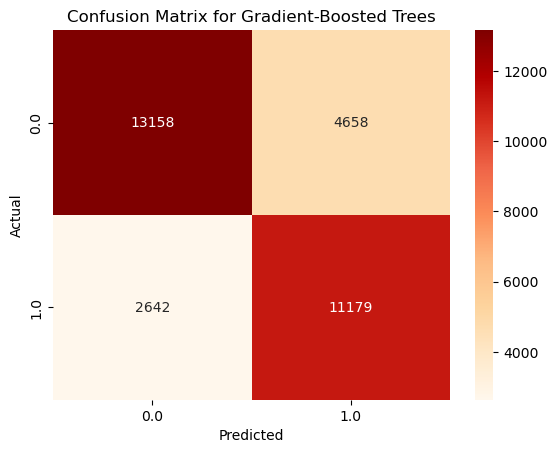

In [84]:
###Evaluate Gradient Boost Model


##Binary Classification Evaluator for AUC (Area Under ROC Curve)
gbt_auc = evaluator.evaluate(gbt_predictions)
print(f"Gradient-Boosted Trees AUC: {gbt_auc}")

##Multiclass Classification Evaluator for accuracy
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="smoking", predictionCol="prediction", metricName="accuracy")
gbt_accuracy = multiclass_evaluator.evaluate(gbt_predictions)
print(f"Gradient-Boosted Trees Accuracy: {gbt_accuracy}")

precision = multiclass_evaluator.setMetricName("weightedPrecision").evaluate(gbt_predictions)
print(f"Logistic Regression Precision: {precision}")

recall = multiclass_evaluator.setMetricName("weightedRecall").evaluate(gbt_predictions)
print(f"Logistic Regression Recall: {recall}")

f1 = multiclass_evaluator.setMetricName("f1").evaluate(gbt_predictions)
print(f"Logistic Regression F1 Score: {f1}")

evalScores["Gradient Boost"] = {"accuracy": gbt_accuracy, "precision": precision, "recall": recall, "f1": f1}
accuracies.append(gbt_accuracy)
precisions.append(precision)
recalls.append(recall)
f1s.append(f1)

##Confusion Matrix
gbt_predictions.groupBy("smoking", "prediction").count().show()

##Visualize the Confusion Matrix

##Convert predictions to Pandas DataFrame
gbt_pandas_predictions = gbt_predictions.select("smoking", "prediction").toPandas()

##Create a confusion matrix
confusion_matrix = pd.crosstab(gbt_pandas_predictions["smoking"], gbt_pandas_predictions["prediction"], rownames=["Actual"], colnames=["Predicted"])

##Plot the confusion matrix
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="OrRd")
plt.title("Confusion Matrix for Gradient-Boosted Trees")
plt.show()


####  Random Forest Evaluation

Random Forest AUC: 0.8292780030206598
Random Forest Accuracy: 0.7522205013117552
Cross-Validated Random Forest AUC: 0.830890556488702
Cross-Validated Random Forest Accuracy: 0.7523785441097449
Logistic Regression Precision: 0.7629253676629397
Logistic Regression Recall: 0.752378544109745
Logistic Regression F1 Score: 0.7533284046006717
+-------+----------+-----+
|smoking|prediction|count|
+-------+----------+-----+
|    1.0|       1.0|11182|
|    0.0|       1.0| 5200|
|    1.0|       0.0| 2639|
|    0.0|       0.0|12616|
+-------+----------+-----+



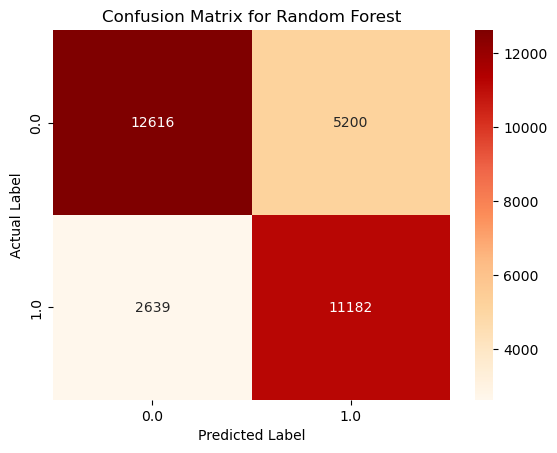

In [86]:
###Evaluate Random Forest


##Binary Classification Evaluator for AUC
evaluator = BinaryClassificationEvaluator(labelCol="smoking", metricName="areaUnderROC")
rf_auc = evaluator.evaluate(rf_predictions)
print(f"Random Forest AUC: {rf_auc}")

##Multiclass Classification Evaluator for Accuracy
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="smoking", predictionCol="prediction", metricName="accuracy")
rf_accuracy = multiclass_evaluator.evaluate(rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy}")

##Cross Validation with Hyperparameter Tuning
#paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [10, 20, 50]).addGrid(rf.maxDepth, [5, 10, 20]).build()
paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [10, 20, 80]).build()


crossval = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5
)

cv_model = crossval.fit(train)
cv_predictions = cv_model.transform(test)

##Evaluate Cross-Validated Model
cv_auc = evaluator.evaluate(cv_predictions)
cv_accuracy = multiclass_evaluator.evaluate(cv_predictions)
print(f"Cross-Validated Random Forest AUC: {cv_auc}")
print(f"Cross-Validated Random Forest Accuracy: {cv_accuracy}")

precision = multiclass_evaluator.setMetricName("weightedPrecision").evaluate(cv_predictions)
print(f"Logistic Regression Precision: {precision}")

recall = multiclass_evaluator.setMetricName("weightedRecall").evaluate(cv_predictions)
print(f"Logistic Regression Recall: {recall}")

f1 = multiclass_evaluator.setMetricName("f1").evaluate(cv_predictions)
print(f"Logistic Regression F1 Score: {f1}")

evalScores["Random Forest"] = {"accuracy": cv_accuracy, "precision": precision, "recall": recall, "f1": f1}
accuracies.append(cv_accuracy)
precisions.append(precision)
recalls.append(recall)
f1s.append(f1)

##Confusion Matrix
rf_predictions.groupBy("smoking", "prediction").count().show()

##Visualize the Confusion Matrix

##Convert predictions to Pandas DataFrame
rf_pandas_predictions = rf_predictions.select("smoking", "prediction").toPandas()

##Create a confusion matrix
confusion_matrix = pd.crosstab(rf_pandas_predictions["smoking"], rf_pandas_predictions["prediction"], rownames=["Actual"], colnames=["Predicted"])

##Plot the confusion matrix
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="OrRd", cbar=True)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix for Random Forest")
plt.show()




### Stage 5: Visualization

The best model with accuracy score is Gradient Boost with a score of: 0.7692575149350445
The best model with precision score is Gradient Boost with a score of: 0.7773443386457308
The best model with recall score is Gradient Boost with a score of: 0.7692575149350445
The best model with f1 score is Gradient Boost with a score of: 0.7701808854268869




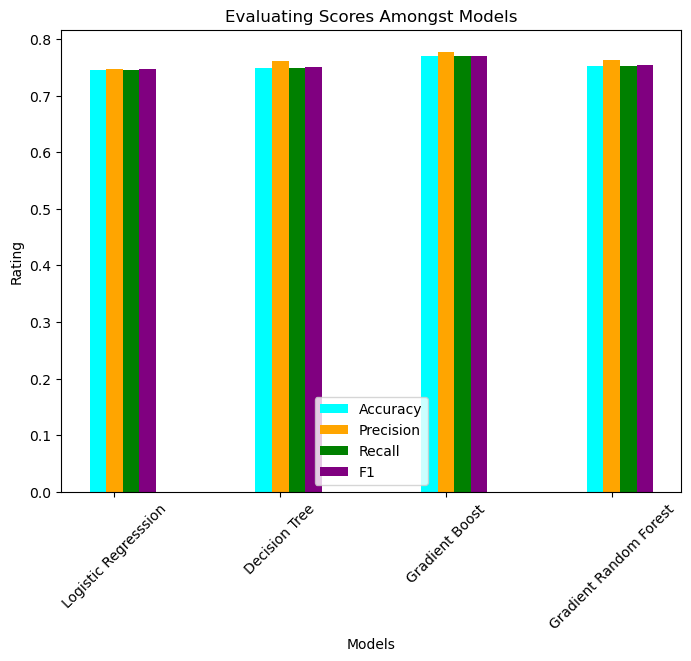

In [100]:
highest = [0,0,0,0]
topModelScores = ["","","",""]

for modelName, evalScore in evalScores.items():
    
    if evalScore["accuracy"] > highest[0]:
        highest[0] = evalScore["accuracy"]
        topModelScores[0] = modelName
        
        
    if evalScore["precision"] > highest[1]:
        highest[1] = evalScore["precision"]
        topModelScores[1] = modelName
        

    if evalScore["recall"] >  highest[2]:
         highest[2] = evalScore["recall"]
         topModelScores[2] = modelName
        

    if evalScore["f1"] > highest[3]:
         highest[3] = evalScore["f1"]
         topModelScores[3] = modelName

print("The best model with accuracy score is", topModelScores[0], "with a score of:",  highest[0])
print("The best model with precision score is", topModelScores[1], "with a score of:",  highest[1])
print("The best model with recall score is", topModelScores[2], "with a score of:",  highest[2])
print("The best model with f1 score is", topModelScores[3], "with a score of:",  highest[3])
print('\n')

x = np.arange(4)
width = 0.1
plt.figure(figsize=(8,6))
plt.title('Evaluating Scores Amongst Models')
plt.bar(x-width, accuracies, width, color='cyan') 
plt.bar(x, precisions, width, color='orange') 
plt.bar(x+width, recalls, width, color='green') 
plt.bar(x+width*2, f1s, width, color='purple') 
plt.xticks(x, list(evalScores.keys()), rotation=45) 
plt.xlabel("Models") 
plt.ylabel("Rating") 
plt.legend(['Accuracy', 'Precision', 'Recall', 'F1']) 
plt.show()

### Limitations, Future Work, and Conclusion

Limitations:
	A big limitation of this dataset is its ability to see only physical characteristics, such as height and weight, but not see other important factors such as how much someone smokes. Additionally, some data in here may be skewing the results, such as the inclusion of height and weight. It has been well documented that the taller someone is, the more they weigh. Although it is not statistically significant enough to show any major changes in results, it is still something to consider.
    
Future Work:
	This dataset is unique in that it is a subset of another dataset generated by a deep learning model, which means you would have to add on to it yourself if you wanted to expand the dataset. Future work could include looking more closely at the physical characteristics and comparing them on an individual basis, so things like smoking to weight, or smoking to dental caries. That would paint a much clearer picture as to what exactly smoking affects physically. Another key detail that would add much needed context is how much someone smokes and the effect that has on someone's physical characteristics. Additionally, the dataset is missing some physical characteristic identifiers, like male and female. Something else to consider for the future would be looking at non physical characteristics, such as marital status, education, family history, and how addicted someone is.
    
Conclusion:
	Looking at the different models, they all score about the same within a just percentage point or two of one another. Gradient Boost performed the best, with Logistic Regression doing the worst as seen above, but it is hard to draw any meaningful conclusion when the models are so close that a difference in seed could flip the outcomes. Something that is interesting we found is that the correlation matrix for each algorithm always seems to produce more false positives than false negatives.
	This project's goal was to analyze physical characteristics of smokers to identify potential patterns through parameter tuning, visualizations, and evaluation with the goal of informing public health strategies and health education efforts. Overall, our results show that there is a correlation between physical characteristics like height, weight, and eyesight to smoking, with all of our algorithms showing at least 0.73 accuracy. This aligns with other studies done about smoking and/overall  genera
health.
